torch.Size([10, 3000, 1])


<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
<>:187: SyntaxWarning: invalid escape sequence '\p'
C:\Users\zazabla\AppData\Local\Temp\ipykernel_16380\1567301528.py:187: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks([np.pi/4, np.pi/2, 3* np.pi/4, np.pi, np

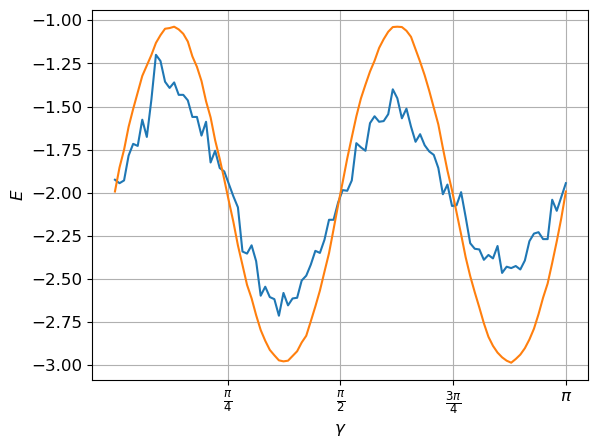

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
from Arbeitsbibliothek.mytoolbox import make_dia, load_file
from Arbeitsbibliothek.myshadow import ShadowShot, ShadowCollection
import networkx as nx
import torch
import torch.nn as nn
import pytorch_lightning as pl
#from torchviz import make_dot
#from torch.utils.tensorboard import SummaryWriter
from Arbeitsbibliothek.myshadow import ShadowShot, ShadowCollection
from Arbeitsbibliothek.qiskit_qaoa import run_qaoa, run_single_qaoa_cir

class BitGeneratorModel(pl.LightningModule):
    def __init__(self, input_dim = 1, output_size =1):
        super().__init__()
        
        self.linear = nn.Linear(input_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        self.lr = 0.01

    def forward(self, x):
        # Berechnen der Wahrscheinlichkeit für den nächsten Bit

        prob = self.linear(x)  # Nehmen Sie nur den letzten Ausgang für jede Sequenz
        
        prob = self.sigmoid(prob)
        
        return prob
        

    def training_step(self, batch, batch_idx):
        x, y = batch
        
        loss_fn = nn.BCELoss(reduction='mean')
        #loss_fn = torch.nn.SmoothL1Loss(reduction='mean')
        #loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        prob = self(x)
        loss = loss_fn(prob, y)
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
def train_model(parameters,Y, output=1, max_iter=600):
    X = [parameters for i in range(len(Y))]
    
    N = len(Y)
    x = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(Y, dtype=torch.float32)
    

    dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=N)
    num_param = len(parameters)
    print("X", num_param)
    print(output)
    model = BitGeneratorModel(num_param, output_size= output) # MyPixelRNN(num_param, hidden_size)
    trainer = pl.Trainer(max_epochs=max_iter, accelerator='auto', devices='auto')
    trainer.fit(model, dataloader)

    return model



def generate_bits(model, parameters, N):
    X = [parameters for i in range(N)]
    x = torch.tensor(X, dtype=torch.float32)
    bits = model(x)
    return bits.detach().cpu().numpy()

def train_models(x, y, myfunc=None, output=1, maxiter=600):
    res = []
    z=0
    for i, j in zip(x, y):
        z +=1
        print("Beginne", z)
        model = train_model(i, j, output=output, max_iter=maxiter)
        array =generate_bits(model, x, len(y))
        #print(generate_bits)
        if myfunc!=None:
            res_ = myfunc(array)
            res.append(res_)
    return res

def take_mean(array):
    array = [[1 if random.random() < prob else 0 for prob in mm] for mm in array]
    return np.mean(array)

######### Training für Blochsphere
x = np.linspace(0, 2 * np.pi, 10)
x_ana = np.linspace(0, 2 * np.pi, 100)
y_ana = np.sin(x_ana/2)**2
y = []
y_bits = []

for i in x:
    prob = np.sin(i/2)**2
    bits = []
    bits_ = []
    for j in range(3000):
        bit = 1 if random.random() < prob else 0
        bits.append([bit])
    y_bits.append(bits)
    #y.append(np.mean(bits))

x_ = [[i] for i in x]
y_ = [[i] for i in y_bits]
y = torch.tensor(y_bits, dtype=torch.float32)
print(y.size())
#y_NN = train_models(x_, y_bits, myfunc=take_mean, maxiter=200)
############

if True:
    ana_list = []
    nn_list = []
    anzahl = 5
    for i in range(anzahl):
        string4 = "FC singleQAOA 1Layer beta2_"
        
        mytuple= load_file(string4 + str(i+1) + ".txt", array=True)
        qaoa = mytuple[0]
        nn = mytuple[1]
        ana_list.append(qaoa)
        nn_list.append(nn)
    ana_list = np.mean(ana_list, axis=0)
    nn_list = np.mean(nn_list, axis=0)


    
xy = np.linspace(0, np.pi, 100)
if False:
######### QAOA
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
    def make_shadow_energy(array):
        array = array[0]#[item for sublist in array for item in sublist]
        array = [[1 if random.random() < prob else 0 for prob in mm] for mm in array]
        print(array)
        global G 
        NNshadow = ShadowCollection([ShadowShot(array, parameters)], gw)
        NNenergie = NNshadow.get_energy_list()[0]
        return NNenergie



    gw = nx.to_numpy_array(G)
    
    para = []
    Ys = []
    Y_ana = []
    for x in xy:
        parameters = [2, x]
        para.append(parameters)
        res, shadow, expec= run_single_qaoa_cir(G, parameters)
        QAOAenergie = shadow.get_energy_list()[0]
        Y_ana.append(QAOAenergie)
        shadow.eliminated_equivalent()
        
        Y = shadow.shadowList[0].shadow
        Ys.append(Y)

        X = [parameters for i in range(len(Y))]
        N = len(Y)
    y_NN = train_models(para, Ys, output=4, myfunc=make_shadow_energy, maxiter=300)

    f = open("FC singleQAOA 1Layer beta2_5.txt", "w")
    fileString = ""
    for q,nn,g in zip(Y_ana, y_NN, xy):
        fileString += str(q) +"\t" + str(nn) +"\t" + str(g) +"\n"
    f.write(fileString)
    f.close()


########

fontsize = 'large'
plt.xlabel(r'$\theta$', fontsize=fontsize)
plt.xlabel(r'$\gamma$', fontsize=fontsize)
#plt.ylabel(r'$\Delta E$', fontsize=fontsize)
plt.ylabel(r'$E$', fontsize=fontsize)
#plt.ylabel(r'$E$', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.grid()
plt.xticks([np.pi/4, np.pi/2, 3* np.pi/4, np.pi, np.pi*(5/4), np.pi*(6/4), np.pi*(7/4), 2*np.pi], ["$\\frac{\pi}{4}$","$\\frac{\pi}{2}$","$\\frac{3\pi}{4}$", "$\pi$", "$\\frac{5\pi}{4}$", "$\\frac{3\pi}{2}$", "$\\frac{7\pi}{4}$", "$2\pi$"])
#plt.scatter(x,y_NN)
#plt.plot(x_ana,y_ana, color='red')
plt.plot(xy,nn_list)
plt.plot(xy,ana_list)


